<a href="https://colab.research.google.com/github/bforoura/AI/blob/main/Module6/CNN_Facial_Expression_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Expression Classification  with Convolutional Neural Networks (CNN)**


* **Convolutional Neural Networks** (CNNs) are a class of deep neural networks, most commonly applied to analyzing visual imagery. They are widely used in tasks such as image recognition, image classification, object detection, and more.

* At a high level, CNNs are inspired by the organization of the visual cortex and are designed to automatically and adaptively learn spatial hierarchies of features from raw input data. This makes them extremely effective for tasks involving images and other types of spatial data.

* CNNs consist of multiple layers, including **convolutional layers**, **pooling layers**, and **fully connected layers**.

* CNNs have revolutionized the field of computer vision and have been instrumental in achieving state-of-the-art performance in various image-related tasks.

* CNN's ability to automatically learn hierarchical representations of data makes them powerful tools for a wide range of applications.

* CNNs can learn to extract features from images that are indicative of emotions such as happiness, sadness, anger, etc.



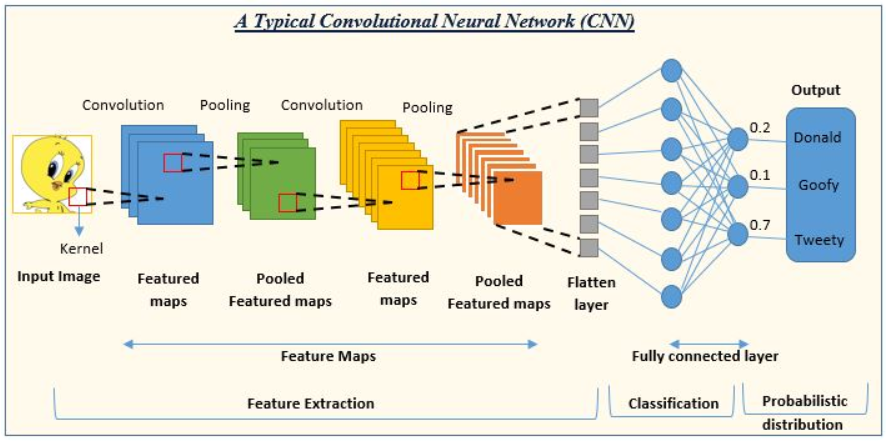


**Convolutional Layer**
* This layer applies a set of filters (kernels) to the input image, which helps extract important features like edges, shapes, and textures.
* Each filter is convolved (slid) across the input image to produce a feature map.


**Pooling Layer**
* The pooling layer downsamples the feature maps generated by the convolutional layers.
* It helps reduce the spatial dimensions of the feature maps while retaining important information.
* Common pooling operations include **max pooling** and **average pooling**.

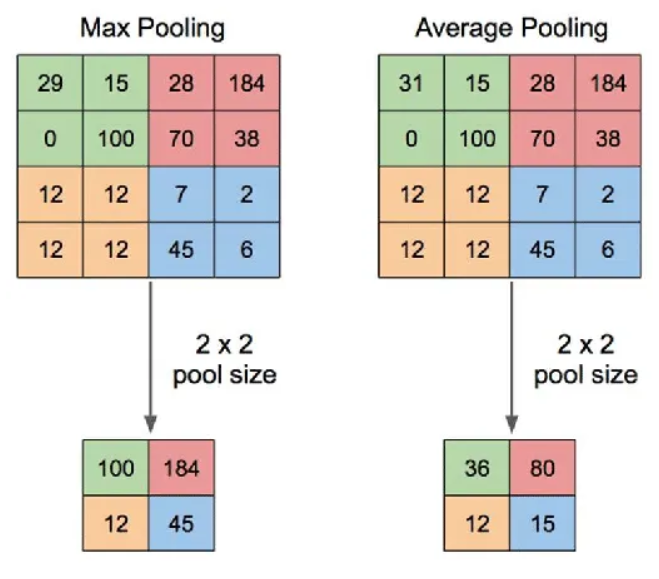

**Fully Connected Layer**
* Also known as the **dense layer**, this layer connects every neuron in the previous layer to every neuron in the current layer.
* It helps in learning non-linear combinations of features from the previous layers.



**Activation Function**
* Typically, each layer in a CNN is followed by an activation function such as **ReLU** (Rectified Linear Unit), which introduces non-linearity into the network, allowing it to learn complex patterns in the data.

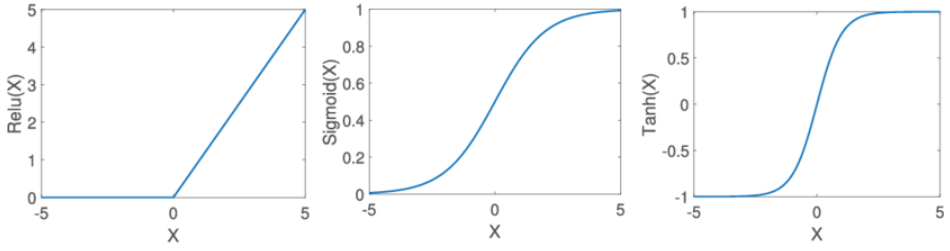



**Softmax Layer**
* In the final layer of a CNN used for classification tasks, a softmax activation function is often used to convert the network's raw output into probability scores for each class.
* This helps in determining the most likely class for the input image.

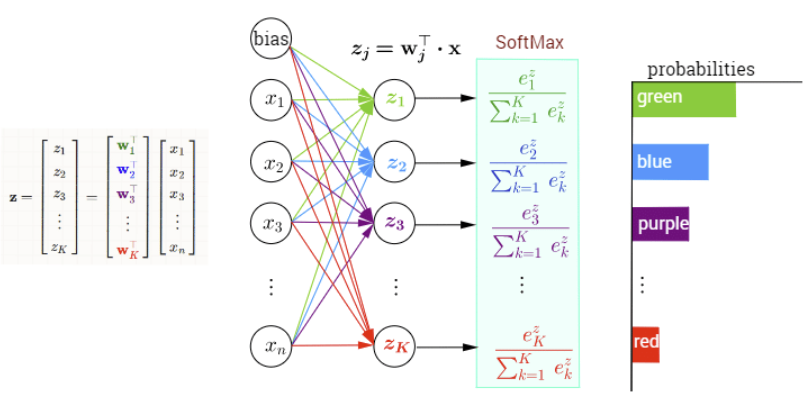

# **The FER-2013 Dataset**

* The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

* The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

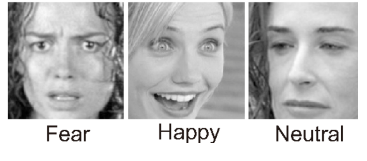

* The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

* https://www.kaggle.com/datasets/msambare/fer2013


In [1]:
!ls drive/MyDrive/'Colab Notebooks'


 alcohol_consumption.ipynb		      linear_regression.ipynb
 anne.ipynb				      linear_regression_Python.ipynb
'AStar (1).ipynb'			      linear_regression_R.ipynb
 AStar.ipynb				      MNIST_CNN.ipynb
' basic_python.ipynb'			      MNIST.ipynb
 basic_python.ipynb			     'naiive_bayes (1).ipynb'
 BFS_Animated.ipynb			      naiive_bayes.ipynb
 BFS.ipynb				      neural_nets_with_keras.ipynb
 Breadth_First_Search.ipynb		      nlp_transformers_ch1_ex1.ipynb
 breast_cancer_MLPClassifier.ipynb	      nlp_transformers_ch2_ex1.ipynb
 breast_cancer_PCA.ipynb		      nlp_transformers_ch3_ex1.ipynb
'Chapter3 (1).ipynb'			      nlp_transformers_ch6_ex1.ipynb
'Chapter3 (2).ipynb'			      nlp_transformers_ch6_ex2.ipynb
' Chapter3.ipynb'			      nlp_transformers_ch6_ex3.ipynb
 Chapter3.ipynb				      nlp_transformers_ch7_ex1.ipynb
'Chapter6 (1).ipynb'			      nlp_transformers_ch8_ex1.ipynb
'Chapter6 (2).ipynb'			      nlp_transformers_ch9_ex1.ipynb
 Chapter6.ipynb				      ploynomial_regression.ipynb
 ch

In [2]:
!cp  drive/MyDrive/'Colab Notebooks'/fer2013.csv  /content


In [3]:
!ls

drive  fer2013.csv  sample_data


# **Note**

* To speed up training, change the execution environment to T4 (instead of CPU)

* The NVIDIA T4 is a GPU that accelerates our workload.

* T4 has 320 Turing Tensor Cores and 2,560 NVIDIA CUDA cores.

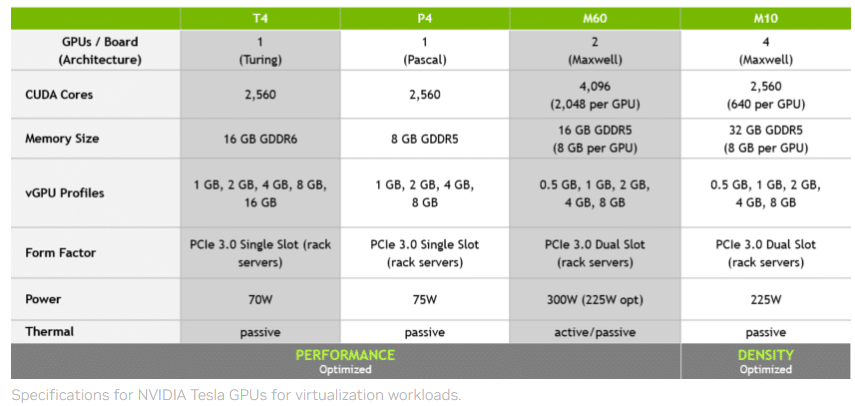

In [17]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from PIL import Image
import os

# Load the dataset from my Google drive and upload it to your own drive
# https://drive.google.com/file/d/1RvyUHg1eQhtmWOuzUxU6QDJYkf4PjR3-/view?usp=sharing
data = pd.read_csv('fer2013.csv')

# Directory to store images
os.makedirs('images', exist_ok=True)

# Prepare the data
X = []
for i, row in data.iterrows():
    pixels = row['pixels'].split()
    pixels = np.array(pixels, dtype='uint8')
    if pixels.size != 48*48:
        continue  # Skip images with incorrect number of pixels
    pixels = pixels.reshape((48, 48))
    image = Image.fromarray(pixels)
    image_path = f'images/{i}.jpg'
    image.save(image_path)
    X.append(pixels.flatten())  # Flatten the image into a 1D array

# Filter out images with incorrect number of pixels
data = data[data['pixels'].apply(lambda x: len(x.split()) == 48*48)]

X = np.array(X).reshape(-1, 48, 48, 1) / 255.0  # Normalize pixel values
y = to_categorical(data['emotion'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)


# Create a CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),

    """
    After applying a Conv2D layer with 32 filters and a kernel size of (3, 3),
    followed by a MaxPooling2D layer with a pool size of (2, 2), the size of the
    data will be reduced (grey scale requires only 1 channel, RGB would have 3).

    new Height: (48 - 3 + 1) / 2 = 23
    new Width: (48 - 3 + 1) / 2 = 23
    Number of Channels: 32 (as specified in the Conv2D layer)
    ==> The size of the data after these transformations: 23 x 23 x 32
    """

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    """
    new Height: (23 - 3 + 1) / 2 = 11
    new Width: (23 - 3 + 1) / 2 = 11
    Number of Channels: 64 (as specified in the second Conv2D layer)
    ==> The size of the data after these transformations: 11 x 11 x 64
    """

    Flatten(),
    """
    The output of the Flatten() layer will be a 1-dimensional array of
    size 11 x 11 x 64 = 7744
    """

    Dense(128, activation='relu'),  # Large dense layer
    """
    We don't have to have a dense layer with 7744 units after the Flatten() layer.
    The size of the dense layer after the Flatten() layer is a design choice and
    depends on the complexity of the problem and the desired model capacity.
    """

    Dense(7, activation='softmax')  # The final dense output layer
    # Seven facial expressions to be classified
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model and save its training history for further analysis
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))



# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')




Epoch 1/10
785/785 [==============================] - 6s 6ms/step - loss: 1.6226 - accuracy: 0.3621 - val_loss: 1.4706 - val_accuracy: 0.4322
Epoch 2/10
785/785 [==============================] - 4s 6ms/step - loss: 1.3985 - accuracy: 0.4640 - val_loss: 1.3569 - val_accuracy: 0.4849
Epoch 3/10
785/785 [==============================] - 6s 8ms/step - loss: 1.2911 - accuracy: 0.5076 - val_loss: 1.3176 - val_accuracy: 0.4970
Epoch 4/10
785/785 [==============================] - 4s 6ms/step - loss: 1.1945 - accuracy: 0.5479 - val_loss: 1.2973 - val_accuracy: 0.5062
Epoch 5/10
785/785 [==============================] - 4s 6ms/step - loss: 1.1047 - accuracy: 0.5795 - val_loss: 1.3030 - val_accuracy: 0.5016
Epoch 6/10
785/785 [==============================] - 4s 5ms/step - loss: 1.0137 - accuracy: 0.6204 - val_loss: 1.2964 - val_accuracy: 0.5182
Epoch 7/10
785/785 [==============================] - 6s 7ms/step - loss: 0.9158 - accuracy: 0.6583 - val_loss: 1.3843 - val_accuracy: 0.5161
Epoch 

In [22]:
# Display info about the model's architecture

model.summary()




Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 6400)              0         
                                                                 
 dense_19 (Dense)            (None, 128)              

# **Explanation of the Model**


## **Conv2d Layer**

* The **Conv2D layer** in this  model is outputting a tensor with a shape of **(None, 46, 46, 32)**.
* This means that the convolutional layer is producing feature maps with a size of 46x46, which is slightly smaller than the input size of 48x48.
* This reduction in size is a result of the convolution operation, which typically uses a filter/kernel size of 3x3 as indicated by (3, 3) in the Conv2D layer.
* The number 32 in the output shape **(None, 46, 46, 32)** corresponds to the number of filters in the convolutional layer, which is set to 32 in our model.

## **Feature Hierarchies**
* A **3x3 filter** is small enough to capture local patterns in the input image, such as edges, corners, and textures, while also being able to capture larger patterns through multiple layers of convolution.
* By stacking multiple layers with 3x3 filters, the network can learn hierarchical features, where early layers learn simple features (e.g., edges) and deeper layers learn more complex features (e.g., shapes).

## **MaxPooling2D Layer**
* This layer reduces the spatial dimensions of the input tensor.
* In this case, it takes the output from the previous convolutional layer and reduces its size by half in both the height and width dimensions.
* The **(None, 23, 23, 32)** indicates that after max pooling, the tensor's spatial dimensions are 23x23, and it has 32 **channels**.

## **Conv2D_1 Layer**
* This is another convolutional layer in the model.
* It takes the output from the previous max pooling layer and applies another set of filters to extract more complex features.
* The **(None, 21, 21, 64)** indicates that the output tensor has spatial dimensions of 21x21 and 64 channels.

## **MaxPooling2D_1 Layer**
* This is another max pooling layer that further reduces the spatial dimensions of the tensor.
*  After this layer, the tensor has dimensions of 10x10 with 64 channels.

## **Flatten Layer (Flatten)**
* This layer flattens the 3D tensor into a 1D tensor, which is necessary before passing the data to the fully connected (Dense) layers.
* In this case, the flattened tensor has a size of 6400 (10x10x64).

## **Dense Layer (Dense)**
* This is a fully connected layer with 128 neurons.
* It takes the flattened tensor as input and performs a linear operation followed by a **ReLU activation**.

## **Dense_1 Layer (Dense)**
* This is the output layer of the network with 7 neurons, which corresponds to the number of classes in the classification task.
* It uses a **softmax activation function** to output probabilities for each class.

## **Role of Channels in CNN**
* Channels refer to the depth dimension of the feature maps produced by convolutional layers.
* Each channel represents a different feature learned by the network.
* For example, in the context of image processing, the first few convolutional layers might learn simple features like edges or textures, which would be represented by different channels.
* As we move deeper into the network, the channels might represent more complex features that are combinations of the simpler features from earlier layers.

* In our model, the channels in the feature maps contain the learned features at different levels of abstraction.
* Each channel in a feature map responds to a different pattern or feature in the input data.
* The number of channels typically increases as you go deeper into the network, allowing the network to learn more complex features

## **Number of CONV2D Layers**
* There is no strict limit to the number of Conv2D layers you can use in a convolutional neural network (CNN). However, the number of layers you should use depends on several factors, including the complexity of the problem, the size of the dataset, and the computational resources available.

* Using a deeper network with more Conv2D layers can help the model learn more complex features and potentially improve performance. However, deeper networks are also more computationally expensive to train and can be prone to overfitting, especially if the dataset is small.

* In practice, it's common to start with a relatively shallow network and gradually increase its depth and complexity based on the performance on a validation set. Techniques like regularization (e.g., dropout) and batch normalization can also help mitigate overfitting in deeper networks.

* Ultimately, the number of Conv2D layers you use should be determined through experimentation and tuning to find the optimal balance between model complexity and performance for your specific problem.



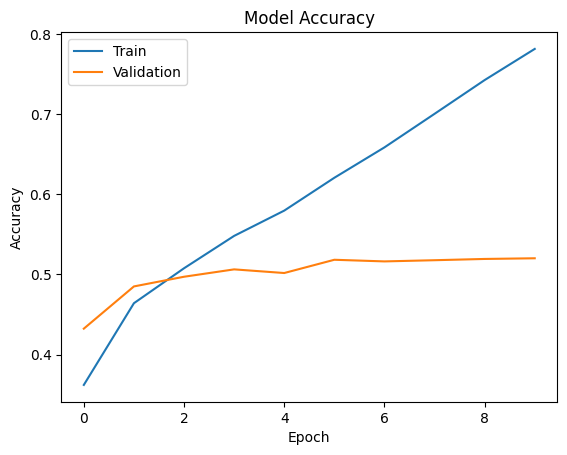

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

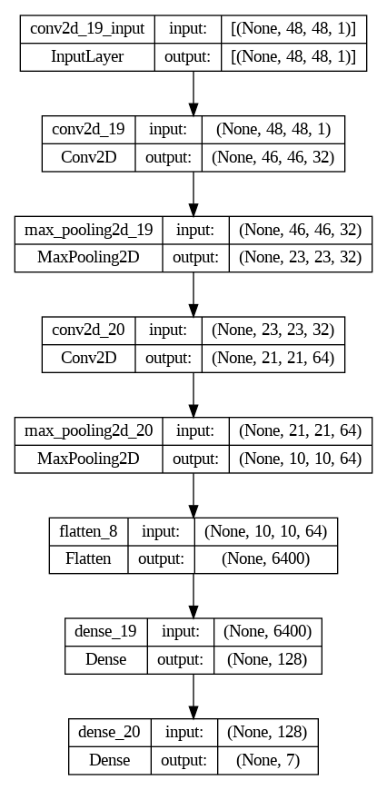

In [27]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Plot the model architecture
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_plot.png')

# Display the model architecture on screen
image = plt.imread('model_plot.png')
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [33]:
# Examine various model layers

hidden1 = model.layers[5]
hidden1.name

weights, biases = hidden1.get_weights()

weights.shape


(6400, 128)

# **Testing the Model on a Few Training Examples**

* Let's pick 10 images and test the models .predict() ability
* Recall that the overall training accuracy of this model is not that high

1/1 [==============================] - 0s 63ms/step


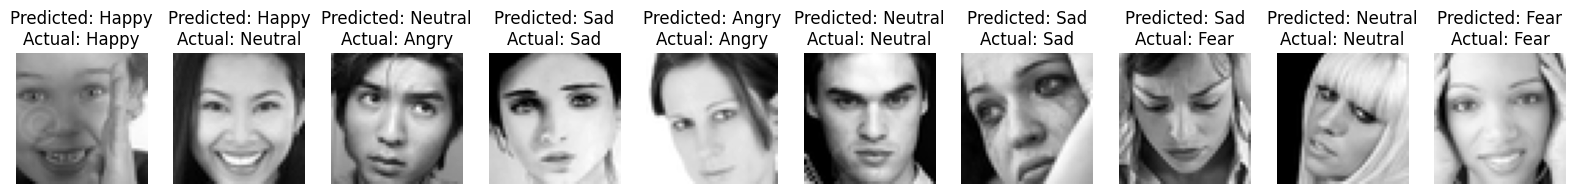

In [21]:
import matplotlib.pyplot as plt

# Select a few images from the test set
num_images = 10
selected_images = X_test[:num_images]
selected_labels = y_test[:num_images]

# Predict the labels for the selected images
predicted_labels = model.predict(selected_images)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Define class labels
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot the selected images with their predicted labels
plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(selected_images[i].reshape(48, 48), cmap='gray')
    plt.title(f'Predicted: {class_labels[predicted_classes[i]]}\nActual: {class_labels[np.argmax(selected_labels[i])]}')
    plt.axis('off')
plt.show()

## **Testing the Model on the FACES Dataset**

* FACES is a set of images of naturalistic faces of 171 young (n = 58), middle-aged (n = 56), and older (n = 57) women and men displaying each of six facial expressions: neutrality, sadness, disgust, fear, anger, and happiness.

* FACES Home: https://faces.mpdl.mpg.de/imeji/

* Download the faces database and save it on your laptop: https://drive.google.com/file/d/1KIr-oCHhZn7gq60XI9cbGP-ibZIS33VE/view?usp=sharing



Saving 1.BMP to 1 (1).BMP
Saving 2.BMP to 2 (1).BMP
Saving 3.BMP to 3 (1).BMP
Saving 4.BMP to 4 (1).BMP
Saving 5.BMP to 5 (1).BMP
Saving 6.BMP to 6 (1).BMP
Saving 7.BMP to 7 (1).BMP
Saving 8.BMP to 8 (1).BMP
Saving 9.BMP to 9 (1).BMP
Saving 10.BMP to 10 (1).BMP
1/1 [==============================] - 0s 18ms/step


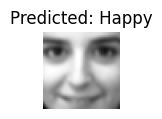

1/1 [==============================] - 0s 23ms/step


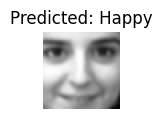

1/1 [==============================] - 0s 29ms/step


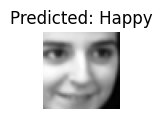

1/1 [==============================] - 0s 25ms/step


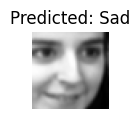

1/1 [==============================] - 0s 23ms/step


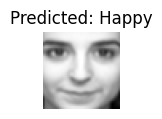

1/1 [==============================] - 0s 20ms/step


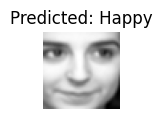

1/1 [==============================] - 0s 28ms/step


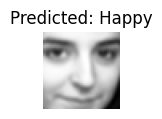

1/1 [==============================] - 0s 24ms/step


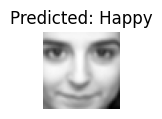

1/1 [==============================] - 0s 25ms/step


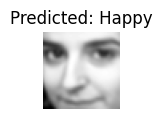

1/1 [==============================] - 0s 26ms/step


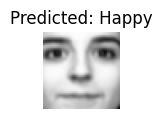

In [35]:
from google.colab import files
from PIL import Image
import numpy as np

# Download the faces database and save on your laptop
#   https://drive.google.com/file/d/1KIr-oCHhZn7gq60XI9cbGP-ibZIS33VE/view?usp=sharing

# Upload the faces database from your local machine
uploaded = files.upload()

# Process and test the uploaded images
for filename in uploaded.keys():
    # Load the image
    image = Image.open(filename)
    image = image.convert('L')  # Convert to grayscale
    image = image.resize((48, 48))  # Resize to 48x48
    pixels = np.array(image)  # Convert to numpy array
    pixels = pixels.reshape(1, 48, 48, 1) / 255.0  # Normalize pixel values and reshape

    # Make predictions
    predicted_labels = model.predict(pixels)
    predicted_class = np.argmax(predicted_labels)
    class_label = class_labels[predicted_class]

    # Display the image and prediction
    plt.figure(figsize=(1, 1))
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted: {class_label}')
    plt.axis('off')
    plt.show()